# CS342 Machine Learning

# Coursework

## Department of Computer Science, University of Warwick


In [1]:
from matplotlib.patches import Ellipse
import numpy as np
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    U, s, Vt = np.linalg.svd(covariance)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height = 2 * np.sqrt(s)

    # Draw the Ellipse
    for nsig in range(1, 5):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

column_names = ["s_length","s,width","p_length","p_width","class"]
dataset = pd.read_csv('./iris.data', header = None , names = column_names)

#Get last column of dataset which is the label of the dataset
classes = dataset.iloc[:,-1:]

#Get all columns except the last columns from the dataset
clean_dataset = dataset.iloc[:,:-1]

#Center dataset by subtracting each data with it's mean.
centered_x = clean_dataset - np.mean(clean_dataset,axis=0)


In [3]:
#SVD function that returns top ith PCA in the vh matrix
def SVD(X,i):
    u, s, vh = np.linalg.svd(X, full_matrices=True)
    return vh[:i]


In [4]:
#Use SVD function to return top 2 PCA in the vh matrix
top2 = SVD(centered_x,2)

#Matrix multiply dataset with the top2 matrix to get 2D data-points
X_V = np.matmul(clean_dataset.to_numpy(),top2.transpose())

#Split X_V into 2 seperate columns X and y
X, y = np.split(X_V ,[-1],axis=1)


In [5]:
#K-means clustering 
from sklearn.cluster import KMeans
#Fit dataset into kmeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_V)

#Predicted labels of dataset according to kmeans
clusterLabels = kmeans.labels_

#Get unique labels in predicted labels
uniqueLabels = np.unique(clusterLabels)

#Get total number of rows in dataset
total_number_of_data = len(X_V)

#Split dataset into groups according to their labels
clusterGroups = {}
for label in uniqueLabels:
    ix = np.where(clusterLabels == label)
    clusterGroups[label] = X_V[ix]


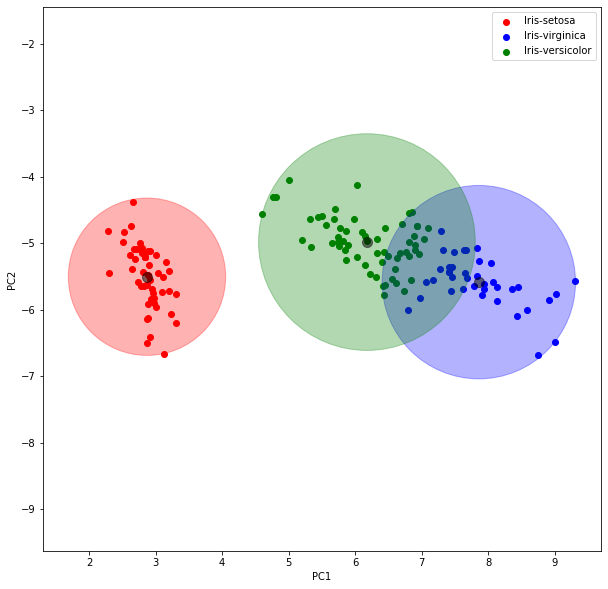

In [6]:
# Section II.C: Display shapes of clusters using add_patch based of Fig.1 as an example

plt.figure(figsize = (10,10))
plt.axis('equal')

cdict = {0: 'r',1:'b' , 2: 'g'}

#Dictionary of labels to their respective names
dictionaryLabels = {0: 'Iris-setosa' , 1: 'Iris-virginica', 2: 'Iris-versicolor'}
counter_radius = 0 
radius=[]
for colorgroup in cdict:
    ix = np.where(clusterLabels == colorgroup)
    plt.scatter(X[ix[0]],y[ix[0]],c = cdict[colorgroup],label = dictionaryLabels[colorgroup])
    max_radius = 0
    for data_points in X_V[ix[0]]:
        
        #Calculate distance between data point and centre and find the maximum distance
        centre = kmeans.cluster_centers_[counter_radius]
        dist = np.linalg.norm(data_points - centre)
        if dist > max_radius:
            max_radius = dist
            
    #Add maximum radius to radius array        
    radius.append(max_radius)
    
    #Increment counter_radius to check for next cluster
    counter_radius = counter_radius + 1
    
color = ['r','b','g']
counter = 0
for i in kmeans.cluster_centers_:
    circ = plt.Circle((i[0], i[1]), radius[counter], color=color[counter], alpha=0.3)
    plt.scatter(i[0],i[1],c='k', s=100, alpha=0.5, zorder=2)
    plt.gca().add_patch(circ)
    counter = counter + 1
    

plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [7]:
#Calculate Accuracy of kmeans
kmeans_total = 0
kmeans_correct = 0
for i in clusterLabels:
    if dictionaryLabels[i.item()] == classes['class'].iloc[kmeans_total]:
        kmeans_correct = kmeans_correct + 1
    kmeans_total = kmeans_total + 1

#Section II.C: Accuracy of the cluster assignment provided by k-means with respect to ground truth labels
kmeans_accuracy = kmeans_correct/kmeans_total * 100
print("Accuracy of the cluster assignment provided by k-means with respect to ground truth labels: " , kmeans_accuracy , "%")

Accuracy of the cluster assignment provided by k-means with respect to ground truth labels:  88.66666666666667 %


In [8]:
#Initialize array for means, covariances and sizes
means = []
covariances = []
sizes = []


# means = np.array(kmeans.cluster_centers_)

#Calculate means, covariances, sizes according to their cluster groups
for key , value in clusterGroups.items():
    means.append(np.mean(value,axis = 0))
    cov = np.cov(value.transpose())
    covariances.append(cov)
    sizes.append(len(value)/total_number_of_data)


In [9]:
#compute responsibility using python built-in implementation of multivariate normal distribution
from scipy.stats import multivariate_normal

#Function that does the Expectation step of EM Algorithm
def e_step():
    new_r_values = []
    total_log_likelihood = 0
    #Loop through datasets for each data points
    for data_points in X_V:
        #Find probability of data point being in cluster 1
        cluster_1_prob = multivariate_normal.pdf(data_points, mean= means[0], cov = covariances[0])
        #Multiply responsibility with cluster 1 size
        responsibility_1 = sizes[0] * cluster_1_prob
        
        #Find probability of data point being in cluster 2
        cluster_2_prob = multivariate_normal.pdf(data_points, mean= means[1], cov = covariances[1])
        #Multiply responsibility with cluster 2 size
        responsibility_2 = sizes[1] * cluster_2_prob
        
        #Find probability of data point being in cluster 3
        cluster_3_prob = multivariate_normal.pdf(data_points, mean= means[2], cov = covariances[2])
        #Multiply responsibility with cluster 3 size
        responsibility_3 = sizes[2] * cluster_3_prob
        
        #Total responsibility 
        total = responsibility_1 + responsibility_2 + responsibility_3

        #Calculate log_likelihood
        total_log_likelihood = total_log_likelihood + np.log(total)
        
        #Add a 1x3 array with the responsibility for each cluster for the data point in the new array 
        new_r_values.append([responsibility_1/total,responsibility_2/total,responsibility_3/total])
        
    #Convert to numpy array 
    np_array_r_values = np.array(new_r_values)
    
    return np_array_r_values , total_log_likelihood



In [10]:
#Function that does the Maximization step of EM Algorithm
def m_step(r_matrix):
    
    #Add all the responsbilities for all data points for each cluster
    total_weights = r_matrix.sum(axis=0)
    
    #Compute new size by dividing the added responsibility for each cluster with the total number of data points
    sizes[0] = total_weights[0]/ total_number_of_data
    sizes[1] = total_weights[1]/total_number_of_data
    sizes[2] = total_weights[2]/total_number_of_data

    for i in range(3):
        #Getting responsbility columns and changing dimensions of the resulting matrix
        r_values_computed = r_matrix[:,i][:, np.newaxis]
        
        #Get total X value of the cluster
        cluster_totalx = np.matmul(r_values_computed.transpose(),X)
        
        #Divide total X by total weight of the cluster to get mean of X for the cluster
        mean_clusterx = cluster_totalx/total_weights[i]
        
        #Get total y value of the cluster
        cluster_totaly = np.matmul(r_values_computed.transpose(),y)
        
        #Divide total y by total weight of the cluster to get mean of y for the cluster
        mean_clustery = cluster_totaly/total_weights[i]
        
        #Change mean array to contain new mean value for the respective cluster
        means[i] = np.concatenate((mean_clusterx,mean_clustery),axis = 0).flatten()
        
        #Center X data with new cluster mean X
        centeredx = X - mean_clusterx

        #Multiply R value with centeredx 
        r_centeredX = r_values_computed * centeredx
        
        #Center y data with new cluster mean y
        centeredy = y - mean_clustery
        
        #Multiply R value with centeredy
        r_centeredy = r_values_computed * centeredy
        
        #Concatenate centeredx and centeredy to make each row of data to show both X and y coordinates
        centeredxy = np.concatenate((centeredx,centeredy), axis =1)
        
        #Concatenate r_centeredX and r_centeredy to make each row of data to show both X and y coordinates
        r_centeredxy = np.concatenate((r_centeredX,r_centeredy), axis =1)
        
        #Get covariance with respect to X and y by matrix multiplying r_centeredxy and centeredxy
        #The product is then divided by the total weight of the cluster
        covariance_xy = np.matmul(r_centeredxy.transpose(),centeredxy)/total_weights[i]
        
        #Change covariances array to contain new covariance value for the respective cluster
        covariances[i] = covariance_xy
    

In [11]:
#Specify number of iterations for convergance

num_iterations = 19

#Specify the difference between old and new likelihood to converge 
log_likelihood_difference_to_converge = 0.0000001
log_likelihood_array = []
accuracy_array = []
old_log_likelihood = 0

dictionaryLabels = {0: 'Iris-setosa' , 1: 'Iris-virginica', 2: 'Iris-versicolor'}

#Repeat EM algorithm for number of iterations specified by num_iterations
for i in range(num_iterations):
    #E step
    new_r_values , log_likelihood = e_step()
    
    #Append computed log_likelihood to array 
    log_likelihood_array.append(log_likelihood)
    
    #If difference between old and new likelihood is smaller than specified number for converge
    if abs(log_likelihood - old_log_likelihood) < log_likelihood_difference_to_converge:
        break
    
    old_log_likelihood = log_likelihood
    
    #Calculate accuracy based on the new responsibility values
    count = 0 
    correct = 0

    for i in new_r_values:
        key = np.argmax(i)
        python_key = key.item()
        if dictionaryLabels[python_key] == classes['class'].iloc[count]:
            correct = correct + 1
        count = count + 1

    accuracy = correct / count * 100
    accuracy_array.append(accuracy)
    
    #M step 
    m_step(new_r_values) 

print("Assignment provided by the EM algorithm with respect to the ground truth labels: " , accuracy)
print("Mean after convergance: " , means)
print("Covariance after convergance: " ,covariances)
print("Size after convergance: " ,sizes)

Assignment provided by the EM algorithm with respect to the ground truth labels:  98.0
Mean after convergance:  [array([ 2.87050234, -5.50524368]), array([ 7.54200878, -5.33337475]), array([ 6.02714995, -5.09041774])]
Covariance after convergance:  [array([[ 0.04777048, -0.05590782],
       [-0.05590782,  0.21472356]]), array([[ 0.5588529 , -0.29314399],
       [-0.29314399,  0.23296731]]), array([[ 0.36747435, -0.21763499],
       [-0.21763499,  0.18751737]])]
Size after convergance:  [0.33333333333331167, 0.35409835207733065, 0.31256831458935763]


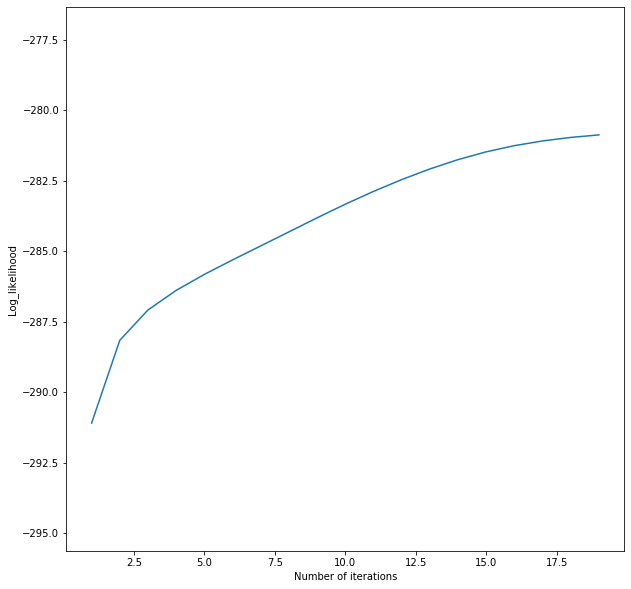

In [12]:
plt.figure(figsize = (10,10))
plt.axis('equal')
iterations_array = np.linspace(1,len(np.array(log_likelihood_array)),num = len(np.array(log_likelihood_array)))
plt.plot(iterations_array,np.array(log_likelihood_array))

plt.ylabel("Log_likelihood")
plt.xlabel("Number of iterations")
plt.show()

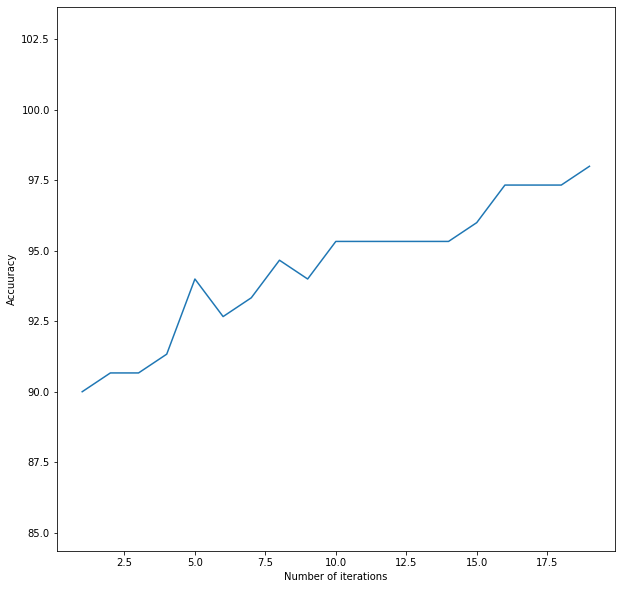

In [13]:
plt.figure(figsize = (10,10))
plt.axis('equal')
iterations_array = np.linspace(1,len(np.array(accuracy_array)),num = len(np.array(accuracy_array)))
plt.plot(iterations_array,np.array(accuracy_array))

plt.ylabel("Accuuracy")
plt.xlabel("Number of iterations")
plt.show()

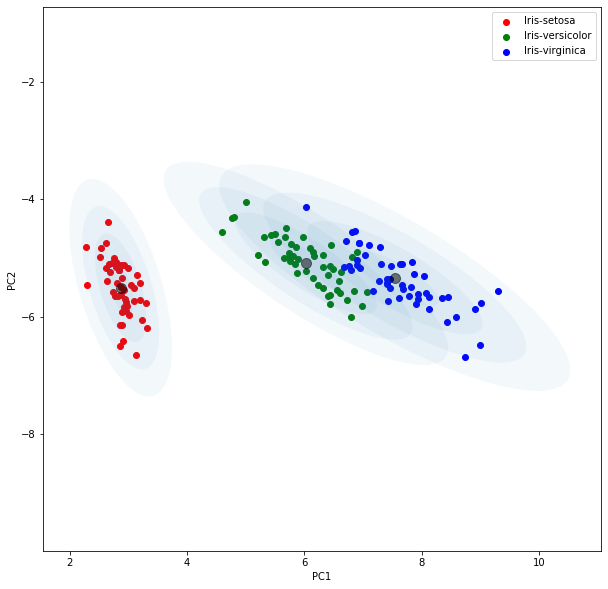

In [14]:
#Section II.C: Cluster Assignment provided by the EM Algorithm as a figure displaying the shape of the clusters 
#Using draw_elipse function
plt.figure(figsize = (10,10))
plt.axis('equal')

alpha_factor = 1/20;  #controls the transparency of the displayed ellipse to simualte a region of probability
for i in range(3):
    plt.scatter(means[i][0],means[i][1],c='black', s=100, alpha=0.5, zorder=2); #draw center of ellipse

    draw_ellipse(means[i], covariances[i], alpha = alpha_factor)

cdict = {'Iris-setosa': 'r', 'Iris-versicolor': 'g' ,'Iris-virginica':'b'}

for colorgroup in cdict:
    ix = np.where(classes == colorgroup)
    plt.scatter(X[ix],y[ix],c = cdict[colorgroup],label = colorgroup)
    
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()